## Tensorflow types

Some notes:
- a tensor can be created with tf.constant function.
- tf.variable is used for weight adjustments, etc
- most of numpy functions will be available in tf, however tf normally creates a copy (eg. tf.transpose instead of a.T)
- strickly typed, which is good. operation cannot be performed between different types, but can be converted.
- c++ underlying
- quite a few different data types (see appendix F)

In [3]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [5]:
t = tf.constant([[1,2,3], [4,5,6]])
t

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [8]:
t.dtype, t.shape

(tf.int32, TensorShape([2, 3]))

In [13]:
t@ tf.transpose(t) # dot product, this is equavalent to tf.matmul

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[14, 32],
       [32, 77]])>

### Keras Low-Level API
Keras also has its own low level api

In [15]:
K = keras.backend
K.square(t)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[ 1,  4,  9],
       [16, 25, 36]])>

In [20]:
v = tf.Variable([[1,2,3],[4,5,6]])
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
array([[1, 2, 3],
       [4, 5, 6]])>

In [21]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]])>

In [22]:
v

<tf.Variable 'Variable:0' shape=(2, 3) dtype=int32, numpy=
array([[ 2,  4,  6],
       [ 8, 10, 12]])>

## Custom loss function

In [23]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

# then pass in the model compile function. 

In [41]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
housing = fetch_california_housing()

keras.backend.clear_session()

# test_size is default to 0.25
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

X_train = StandardScaler().fit_transform(X_train)
X_valid = StandardScaler().fit_transform(X_valid)
X_test = StandardScaler().fit_transform(X_test)

model = tf.keras.Sequential([
        tf.keras.layers.Dense(30, input_shape = X_train.shape[1:], 
                              kernel_initializer = 'he_normal',  activation = 'elu'), # just using shape from training set
        tf.keras.layers.Dense(256, kernel_initializer = 'he_normal', activation = 'elu'),
        tf.keras.layers.Dense(256, kernel_initializer = 'he_normal', activation = 'elu'),
        tf.keras.layers.Dense(128, kernel_initializer = 'he_normal', activation = 'elu'),
        tf.keras.layers.Dense(64, kernel_initializer = 'he_normal', activation = 'elu'),
        tf.keras.layers.Dense(1)
])

model.compile(loss = huber_fn, optimizer = 'adam')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs = 30, verbose= False)

mse_test = model.evaluate(X_test, y_test)

162/162 [==============================] - 0s 685us/step - loss: 0.1717


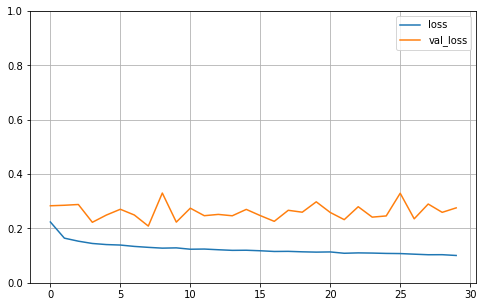

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0,1)
plt.show()

In [43]:
model.save('./california_with_huber_cust.H5')

INFO:tensorflow:Assets written to: ./california_with_huber_cust.H5\assets


In [44]:
model = keras.models.load_model('./california_with_huber_cust.H5', custom_objects={"huber_fn": huber_fn})

In [45]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                270       
_________________________________________________________________
dense_1 (Dense)              (None, 256)               7936      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 115,215
Trainable params: 115,215
Non-trainable params: 0
__________________________________________________

In [ ]:
## The proper implementation 

class HuberLoss(keras.losses.Loss):
    def __init__(self, threhold = 1.0, **kwargs):
        self.threhold = threhold
        super().__init__(**kwargs)
    
    def call(self, y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threhold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threhold * tf.abs(error) - self.threhold**2 / 2
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    # get configu method returns a dictionary mapping each hyperparameter name to its value.
    def get_confg(self):
        base_config = super().get_config()
        return {**base_conig, "threshold": self.threhold}

## Customer Activation Functions, Initialisers, Regularisers and Constraints

All can be implemented in similar ways. most of time, can just write a function with specific input and output

In [46]:
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1)

def my_glorot_initializer(shape, dtype = tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype = dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights):
    return tf.where(weights < 0., tf.zeros_like(weights), weights)


In [1]:
## See page 389 - 399 for more details

In [2]:
!git add 9_custom_models.ipynb
!git commit -m "initial commit"
!git push

The file will have its original line endings in your working directory


[master 61e93b1] initial commit
 1 file changed, 434 insertions(+)
 create mode 100644 tensorflow/9_custom_models.ipynb


To https://github.com/auslei/python.git
   6ed5243..61e93b1  master -> master


In [ ]:
pl